In [1]:
import pandas as pd

# Load the data
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")


# Merge Transactions with Customers
customer_transactions = transactions.merge(customers, on="CustomerID")

# Merge again with Products to add category and price information
customer_data = customer_transactions.merge(products, on="ProductID")

# Display the first few rows to see the combined dataset
print(customer_data.head())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving Bluetooth Speaker

In [2]:
# Calculate total spending per customer
customer_spending = customer_data.groupby("CustomerID")["TotalValue"].sum()

# Count products purchased per category
category_counts = customer_data.pivot_table(
    index="CustomerID", columns="Category", values="Quantity", aggfunc="sum", fill_value=0
)

# Add region information
region_info = customers.set_index("CustomerID")["Region"]

# Combine all into one DataFrame
customer_profile = pd.concat([customer_spending, category_counts, region_info], axis=1)
customer_profile.columns = ["TotalSpend"] + list(category_counts.columns) + ["Region"]

# Convert 'Region' into numbers (for similarity calculations)
customer_profile["Region"] = customer_profile["Region"].astype("category").cat.codes

# Display the customer profile
print(customer_profile.head())


            TotalSpend  Books  Clothing  Electronics  Home Decor  Region
CustomerID                                                              
C0001          3354.52    2.0       0.0          7.0         3.0       3
C0002          1862.74    0.0       4.0          0.0         6.0       0
C0003          2725.38    0.0       4.0          4.0         6.0       3
C0004          5354.88    8.0       0.0          6.0         9.0       3
C0005          2034.24    0.0       0.0          4.0         3.0       0


In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

# Scale the customer profile data
scaler = MinMaxScaler()
customer_profile_scaled = pd.DataFrame(
    scaler.fit_transform(customer_profile),
    index=customer_profile.index,
    columns=customer_profile.columns
)

# Fix missing and infinite values
customer_profile_scaled = customer_profile_scaled.replace([float('inf'), -float('inf')], float('nan'))
customer_profile_scaled = customer_profile_scaled.fillna(0)

# Perform KMeans clustering
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(customer_profile_scaled)

# Add cluster labels to the customer profile
customer_profile['Cluster'] = clusters

# Evaluate clustering performance
db_index = davies_bouldin_score(customer_profile_scaled, clusters)
print(f"Davies-Bouldin Index: {db_index:.2f}")


Davies-Bouldin Index: 1.69


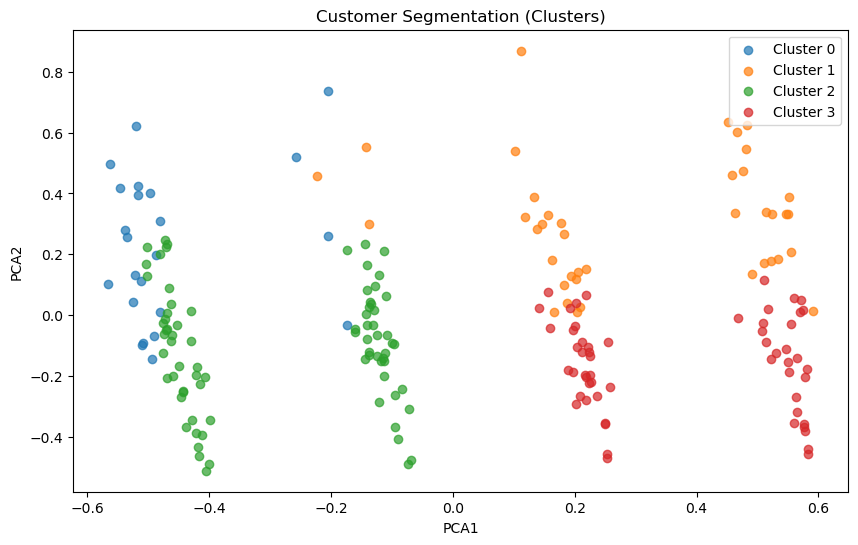

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce data to 2 dimensions using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(customer_profile_scaled)

# Add the reduced dimensions to the profile for plotting
customer_profile['PCA1'] = reduced_data[:, 0]
customer_profile['PCA2'] = reduced_data[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in range(k):
    cluster_data = customer_profile[customer_profile['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}', alpha=0.7)

plt.title('Customer Segmentation (Clusters)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()


In [5]:
# Summary statistics for each cluster
print(customer_profile.groupby('Cluster').mean())


          TotalSpend     Books  Clothing  Electronics  Home Decor    Region  \
Cluster                                                                       
0        5272.001739  8.391304  3.652174     4.391304    1.478261  2.826087   
1        5383.287000  4.275000  4.800000     4.625000    5.450000  0.625000   
2        2913.742911  2.354430  2.556962     3.025316    3.329114  2.506329   
3        2161.795614  2.298246  1.964912     1.789474    2.175439  0.534483   

             PCA1      PCA2  
Cluster                      
0       -0.463234  0.230021  
1        0.296440  0.302853  
2       -0.287546 -0.104438  
3        0.370912 -0.157828  
